# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved July 17, 2024 from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

# New Scoring (After Reset)
- Steps 1 to 6 uses `test_size=0.3` and `n_fold=10`
- Steps 7+ uses `test_size=0.2` and `n_fold=5`

1) Base RF with training on ALL train data (.8102)
- Drop minimal features
- Original Preprocessing (threshold 50)
  - less than threshold = 'Other'
- RF (seed 42, depth 25)
- **Original Preprocessing > New Preprocessing**

2) Base RF (.8094)
- Drop `wpt_name` and `scheme_name`
  - Reduced score
- **Keep features**

3) Base RF (.8077)
- Drop duplicate features but kept `wpt_name` and `scheme_name`
  - Reduced score further
- **Keep features**

4) Previous HP Tuned RF on ALL train data (.8155)
- Kept all features
- Used HP Tuned RF from previous model (via Optuna)
- **Use HP Tuning**

5) HP Tuned RF (.8156)
- Log transformed `amount_tsh` and `population`
- **Transform features**

6) HP Tuned RF (.8159)
- Imputed zero values for `longitude` and `latitude`
- **Impute features**

7) HP Tuned LGBM (.8042)
- RF preprocessing steps but used LGBM
- 80/20 TTS
- Error: Because of 80/20 split, used LE for `ward`
  - Made model WORSE in both CV and TTS
- **Try LGBM OHE**

8) ~HP Tuned CB (.7973)
- RF preprocessing steps but used CB
- 80/20 TTS
- Error: Because of 80/20 split, used LE for `ward`
- **Try CB OHE**

9) HP Tuned LGBM (.8126)
- Converted 'object' to 'categorical' dtype from X_train (X_train_cat)
- Used `categorical_feature='auto'`
- Kept 80/20 TTS
- **LGBM: use internal OHE**

10) HP Tuned CB (.7634)
- Used CB's grid_search
- `auto_class_weights='Balanced'` helped with 'functional needs repair'
- But overall accuracy score dropped to ~0.73
- Consider keeping for soft voting?

11) HP Tuned CB (.8069)
- **Remove `auto_class_weights`**

12) HP Tuned CB (.8088)
- **Add `one_hot_max_size=200`**

13) HP Tuned RF (.8157)
- **70/30 TTS was higher score**

14) Soft Voting (.8207)
- **Balanced Classes (1/3 each)**

15) Soft Voting (.8203)
- Weighted .37/.33/.30

16) Soft Voting w/ Threshold 30 (.8212)
- **Changed threshold for 'INFREQUENT' to 30**

17) Soft Voting w/ Threshold 10 (.8191)
- Not as good as 30

18) Soft Voting w/ `num_private` feature (.8205)
- Made worse; good to drop feature

## Next Steps
- Clean up notebooks and upload to GitHub

**If Possible**
- Does all lowercase help? (Probably not)

# EDA Summary:

- No duplicated rows
- 8 features with missing values (`scheme_name` is 35% missing)

#### Target Variable
- `status_group` - Target Variable (3 categories)
	- Consider preprocessing for class imbalance
	- Because final metric is **Classification Rate**, class weights can hurt score

## Changes Needed BEFORE Data Split

#### Dropped Features
- `num_private` - unknown
	- Drop from dataset
- `recorded_by` - Group entering this row of data
	- All the same company; drop feature

#### Initially dropped, but kept because it helped score
- `scheme_name` - Who operates the waterpoint
	- Majority category is missing values
	- Can use `scheme_management`
- `region_code` - Geographic location (coded)
	- Convert to categorical
- `wpt_name` - Name of the waterpoint if there is one
	- Most common value is 'none'
	- Convert missing values to 'unknown' (only 2)
- `payment` - What the water costs
	- Essentially the same as `payment_type`
- `quality_group` - The quality of the water
	- Essentially the same as `water_quality`
- `quantity_group` - The quantity of water
	- Essentially the same as `quantity`
- `source_type` - The source of the water
	- Essentially the same as `source`
- `waterpoint_type_group` - The kind of waterpoint
	- Essentially the same as `waterpoint_type`

#### Numeric Features
- `amount_tsh` - Total static head (amount water available to waterpoint)
	- Log transformation (np.log1p is fine)
- `population` - Population around the well
	- np.log1p transformation looks great
- `longitude` - GPS coordinate
	- Some 0 values (which would not exist in Tanzania)
	- Impute with median `longitude` based on `region_code`
- `latitude` - GPS coordinate
	- Refer to longitude (0 values are actually not zero)
- `gps_height` - Altitude of the well
	- Looks fairly balanced between `status_groups`; no change needed

#### Date Features
- `date_recorded` - The date the row was entered
	- Convert to pd.datetime()
- `construction_year` - Year the waterpoint was constructed
	- ~35% of values have year = 0; turning into categorical

## Changes Needed AFTER Data Split

### Categorical Features
- `funder` - Who funded the well
	- Includes na and 0 values
	- 0 values in `funder` and `installer` are the same in test_features and train_features
- `installer` - Organization that installed the well
	- Includes na and 0 values
- `subvillage` - Geographic location
	- Some categories as single letters or numbers.
	- Rename missing values to 'nan'
- `district_code` - Geographic location (coded)
	- Convert to categorical
- `public_meeting` - True/False (boolean)
	- Has missing values; convert to 'nan'
- `scheme_management` - Who operates the waterpoint
	- Convert missing values to 'nan'
- `permit` - If the waterpoint is permitted (boolean)
	- Convert missing values to 'nan'

### No Changes Needed (Categorical Features)
- `basin` - Geographic water basin
- `region` - Geographic location
- `lga` - Geographic location
- `ward` - Geographic location
- `extraction_type` - The kind of extraction the waterpoint uses
- `extraction_type_group` - The kind of extraction the waterpoint uses
- `management` - How the waterpoint is managed
- `management_group` - How the waterpoint is managed
- `payment_type` - What the water costs
- `water_quality` - The quality of the water
- `quantity` - The quantity of water
- `source` - The source of the water
- `source_class` - The source of the water
- `waterpoint_type` - The kind of waterpoint

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, \
                                    GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, accuracy_score

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
train_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_values.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/test_values.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/SubmissionFormat.csv')

Mounted at /content/drive


In [ ]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Additional EDA
Look at unique values that may exist in `test_features` that doesn't exist in `train_features`

In [ ]:
# Omit numeric cols, 'id', and 'status_group' (y-label)
omit_cols = ['id', 'amount_tsh', 'gps_height', 'longitude',
             'latitude', 'num_private', 'population', 'status_group']

# Convert 'region_code' and 'district_code' to object dtype
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')
test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')

# Filter out columns in omit_cols that exist in the DataFrame
omit_cols_train = [col for col in omit_cols if col in train_df.columns]
omit_cols_test = [col for col in omit_cols if col in test_features.columns]

train_filtered = train_df.drop(columns=omit_cols_train)
test_filtered = test_features.drop(columns=omit_cols_test)

# Create a table that counts the unique values in each feature in train_filtered
# and compares them to the counts of unique values in test_filtered

# Initialize a list to store the results
unique_counts = []

# Iterate over the columns in train_filtered
for column in train_filtered.columns:
    # Count unique values in train_filtered and test_filtered
    train_unique_count = train_filtered[column].nunique()
    test_unique_count = test_filtered[column].nunique()

    # Append the results to the list
    unique_counts.append({
        'feature': column,
        'train': train_unique_count,
        'test': test_unique_count
    })

# Convert the list to a DataFrame
unique_counts_df = pd.DataFrame(unique_counts)

unique_counts_df

,feature,train,test
0,date_recorded,356,331
1,funder,1896,979
2,installer,2145,1091
3,wpt_name,37399,10840
4,basin,9,9
5,subvillage,19287,8443
6,region,21,21
7,region_code,27,26
8,district_code,20,20
9,lga,125,125


#### Unique Values in Submission Dataset
There are some unique values in `funder`, `installer`, and `wpt_name`, but there is nothing greater than 4.

Low value variables can be combined as 'INFREQUENT'.

# Preprocessing

### Outline
- Convert columns to object (or categorical) datatype and drop columns from both datasets
- Split dataset first to prevent data leakage
- Make necessary changes to both test and submission datasets

#### Note:
- Scoring improved when keeping certain features, even though some appeared to be duplicates. Features include:
  - Duplicates:
    - `region`, `payment`, `quality_group`, `quantity_group`, `source_type`, `waterpoint_type_group`
  - Too many categories:
    - `scheme_name`, `wpt_name`


In [ ]:
# Convert 'region_code' and 'district_code' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')
train_df['construction_year'] = train_df['construction_year'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')
test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

# Log Transform 'amount_tsh' and 'population'
train_df['amount_tsh_log'] = np.log1p(train_df['amount_tsh'])
train_df['population_log'] = np.log1p(train_df['population'])
test_features['amount_tsh_log'] = np.log1p(test_features['amount_tsh'])
test_features['population_log'] = np.log1p(test_features['population'])

# Drop unneccessary columns
train_df = train_df.drop(
    columns=[
        'num_private', 'recorded_by',               # irrelevant
        'date_recorded',                            # new features made
        'amount_tsh', 'population',                 # log transformed
])

test_features = test_features.drop(
    columns=[
        'id',
        'num_private', 'recorded_by',               # irrelevant
        'date_recorded',                            # new features made
        'amount_tsh', 'population',                 # log transformed
])

## Split `train_df` into train and test sets before additional encoding to prevent data leakage

In [ ]:
X = train_df.drop(columns=['status_group','id'], axis=1)
y = train_df['status_group']

# Split train_df into 80% train and 20% test, stratified by y ('status_group')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42)

In [ ]:
# Impute 0 values in 'longitude' and 'latitude'
region_medians = X_train.groupby('region_code')[['longitude',
                                                 'latitude']].median()

#Impute missing values in the training set where longitude or latitude is ~0
X_train['longitude'] = X_train.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)

X_train['latitude'] = X_train.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

# Apply the same imputation to the test set using medians from the training set
X_test['longitude'] = X_test.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)
X_test['latitude'] = X_test.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

# Apply the same imputation to the test set using medians from the training set
test_features['longitude'] = test_features.apply(
    lambda row: region_medians.loc[row['region_code'], 'longitude'] \
    if row['longitude'] == 0 else row['longitude'], axis=1
)
test_features['latitude'] = test_features.apply(
    lambda row: region_medians.loc[row['region_code'], 'latitude'] \
    if row['latitude'] == -2.000000e-08 else row['latitude'], axis=1
)

In [ ]:
# Fill Categorical Columns with missing values in X_train, X_test,
# and test_features with 'nan'
categorical_columns = X.select_dtypes(include=['object']).columns

X_train[categorical_columns] = X_train[categorical_columns].fillna('nan')
X_test[categorical_columns] = X_test[categorical_columns].fillna('nan')
test_features[categorical_columns] = test_features[categorical_columns].fillna('nan')

## Encoding

Base Steps:
1. Convert values with less than the threshold to 'INFREQUENT'
2. One Hot Encoding if less than the threshold
3. Label Encoding if over the threshold

In [ ]:
%%time
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name'
# if less than threshold. Can adjust value in future iterations

# Define the columns to be transformed
columns_to_transform = [
    'funder',
    'installer',
    'wpt_name',
    'subvillage',
    'scheme_name',
    'ward'
]

# Function to replace infrequent categories with 'Other'
def replace_infrequent_categories(df, columns, threshold=50):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'INFREQUENT')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

CPU times: user 3min 21s, sys: 684 ms, total: 3min 22s
Wall time: 3min 53s


In [ ]:
# Count number of categories per categorical column
from collections import defaultdict

# Function to count categories in each categorical column
def count_categories(df):
    category_counts = defaultdict(int)
    for column in df.select_dtypes(include=['object']).columns:
        category_counts[column] = df[column].nunique()
    return category_counts

# Get category counts for X_train, X_test, and test_features
category_counts_X_train = count_categories(X_train)
category_counts_X_test = count_categories(X_test)
category_counts_test_features = count_categories(test_features)

# Combine the counts into a single dataframe for easier inspection
combined_category_counts = pd.DataFrame({
    'X_train': pd.Series(category_counts_X_train),
    'X_test': pd.Series(category_counts_X_test),
    'test_features': pd.Series(category_counts_test_features)
})

combined_category_counts.sort_values(by='X_train', ascending=False)

,X_train,X_test,test_features
ward,187,2,6
lga,124,125,125
funder,123,42,49
installer,121,30,41
scheme_name,59,11,15
subvillage,44,7,9
wpt_name,30,8,10
region,21,21,21
extraction_type,18,18,17
extraction_type_group,13,13,13


# The Path Divides
- Random Forest needs additional preprocessing to convert categorical features to numeric
  - Use OneHotEncoding and LabelEncoding (if needed)
- LGBM and CatBoost can end preprocessing here
  - Better to use internal OHE features of respective models
  - Continue with Model Selection in next notebook

In [ ]:
# RandomForest Additional Preprocessing Steps

# Threshold for OneHotEncoding
threshold = 200

# Identify categorical features and their unique value counts
categorical_features = X_train.select_dtypes(include=['object']).columns
category_counts = X_train[categorical_features].nunique()

# Separate features based on the threshold
onehot_features = category_counts[category_counts < threshold].index.tolist()
labelencode_features = category_counts[category_counts >= threshold].index.tolist()

In [ ]:
# Depending on threshold set, may not need LabelEncoding
print('Label Encode features:\n', labelencode_features)
print('One Hot Encode features:')
onehot_features

[]



['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [ ]:
# Convert boolean features to strings
X_train[onehot_features] = X_train[onehot_features].astype(str)
X_test[onehot_features] = X_test[onehot_features].astype(str)

# Apply OneHotEncoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train[onehot_features])
X_test_ohe = ohe.transform(X_test[onehot_features])

# Do the same for test_features
test_features[onehot_features] = test_features[onehot_features].astype(str)
test_features_ohe = ohe.transform(test_features[onehot_features])

In [ ]:
# Apply Label Encoding
label_encoders = {}
for col in labelencode_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    # Use fit_transform on X_test to handle unseen labels
    X_test[col] = X_test[col].astype(str).map(
        lambda s: 'nan' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, 'nan')
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Combine OneHotEncoded and LabelEncoded features with numeric features
X_train_encoded = pd.DataFrame(
    X_train_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_test_encoded = pd.DataFrame(
    X_test_ohe, columns=ohe.get_feature_names_out(onehot_features))

X_train_final = pd.concat(
    [X_train_encoded.reset_index(drop=True),
     X_train[labelencode_features + \
             X.select_dtypes(include=['number']).columns.tolist()
             ].reset_index(drop=True)], axis=1)

X_test_final = pd.concat(
    [X_test_encoded.reset_index(drop=True),
     X_test[labelencode_features + \
            X.select_dtypes(include=['number']).columns.tolist()
            ].reset_index(drop=True)], axis=1)

print(f'Number of features after encoding: {X_train_final.shape[1]}')

Number of features after encoding: 870


In [ ]:
# Label Encode for test_features
for col in labelencode_features:
    if col in test_features.columns:
        le = label_encoders[col]
        test_features[col] = test_features[col].map(
            lambda s: 'nan' if s not in le.classes_ else s)
        le.classes_ = np.append(le.classes_, 'nan')
        test_features[col] = le.transform(test_features[col])

test_features_encoded = pd.DataFrame(
    test_features_ohe,
    columns=ohe.get_feature_names_out(onehot_features)
)

test_features_final = pd.concat(
    [test_features_encoded.reset_index(drop=True),
     test_features[labelencode_features + X.select_dtypes(
         include=['number']).columns.tolist()].reset_index(drop=True)
    ], axis=1
)

### Continue to Model Selection

# Cross-validation

In [ ]:
# Stratified because of class imbalance
stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Random Forest

In [ ]:
# Create a base and HP tuned model
base_rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=25
)

rf_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=69,
    max_features=0.7385480758096516,
    min_samples_leaf=3,
    min_samples_split=9,
    n_estimators=250,
    n_jobs=-1,
    random_state=42,
)

In [ ]:
%%time

# Stratified KFold CV (takes some time!)
base_rf_scores = cross_val_score(
    base_rf_model, X_train_final, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

rf_scores = cross_val_score(
    rf_model, X_train_final, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

In [ ]:
print(base_rf_scores)
print("Base Random Forest mean score: ", base_rf_scores.mean())
print()
print(rf_scores)
print("Tuned Random Forest mean score: ", rf_scores.mean())

[0.78581876 0.79534981 0.78760384 0.78222042 0.79116495]
Base Random Forest mean score:  0.7884315562162031

[0.79256471 0.79910391 0.79263836 0.79031777 0.7965233 ]
Tuned Random Forest mean score:  0.7942296096236735


In [ ]:
%%time
# Fit RF Model
rf_model.fit(X_train_final, y_train)
rf_preds = rf_model.predict(X_test_final)

print(f"Accuracy: {accuracy_score(y_test, rf_preds)}")
print("Random Forest Classification Report:\n", classification_report(y_test, rf_preds))

Accuracy: 0.8072390572390572
Random Forest Classification Report:
                          precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.61      0.28      0.38       863
         non functional       0.85      0.77      0.80      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.81      0.80     11880

CPU times: user 15min 2s, sys: 3.36 s, total: 15min 6s
Wall time: 9min 43s


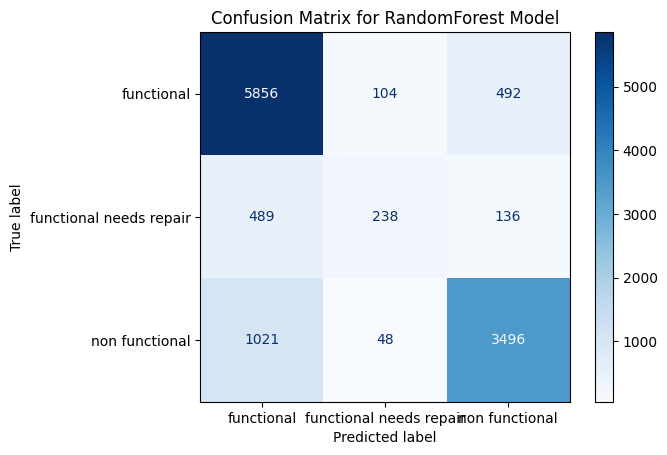

In [ ]:
# Generate confusion matrix
rf_cm = confusion_matrix(y_test, rf_preds)

# Display confusion matrix
rf_disp = ConfusionMatrixDisplay(
    confusion_matrix=rf_cm, display_labels=rf_model.classes_)

rf_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for RandomForest Model')
plt.show()

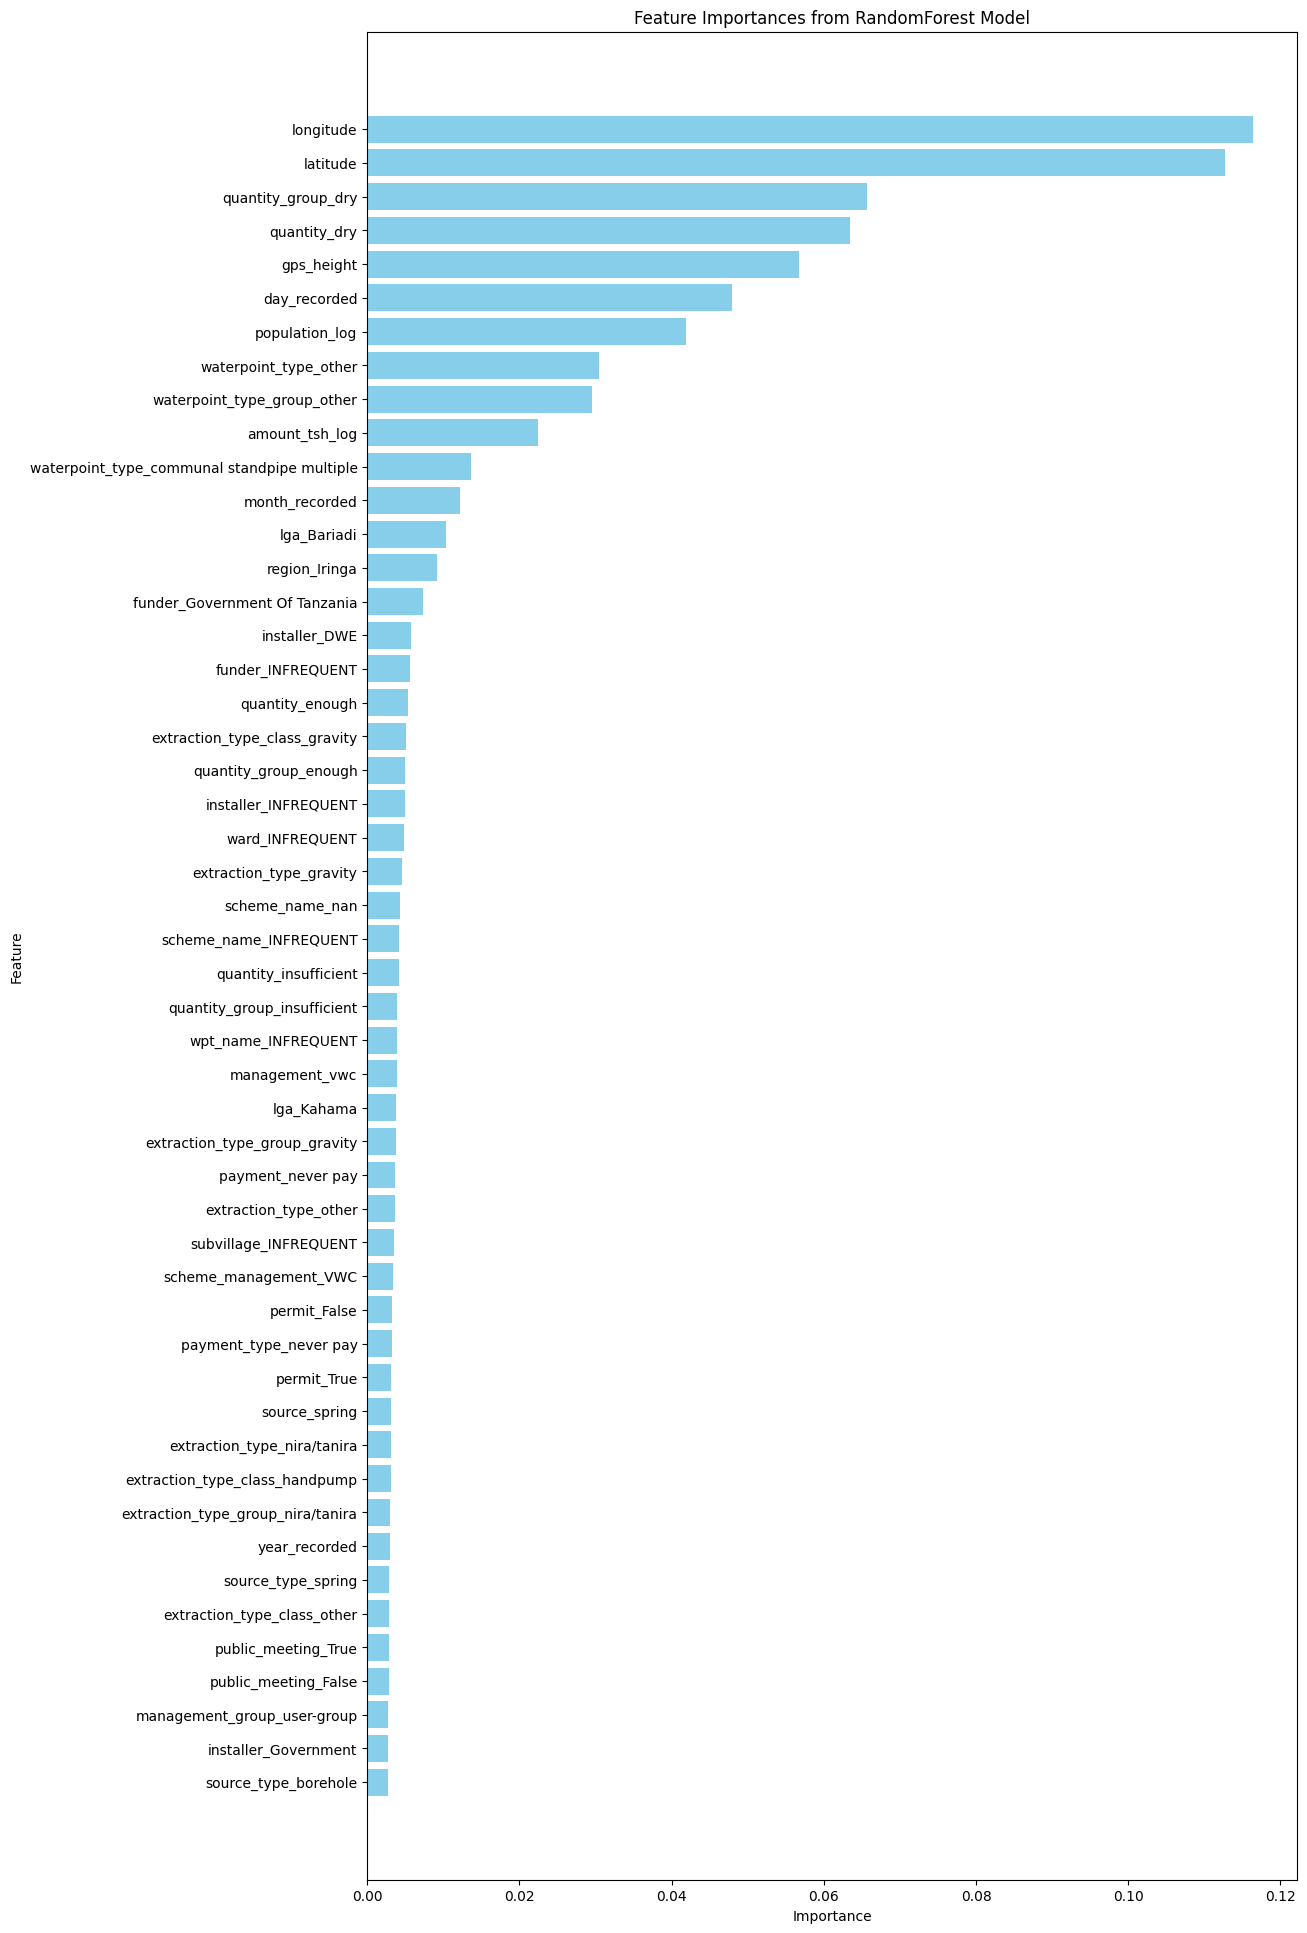

In [ ]:
# Get feature importances from the RandomForest model
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': rf_feature_importances
})

# Sort the DataFrame by importance
rf_features_df = rf_features_df.sort_values(by='Importance', ascending=False).head(50)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(rf_features_df['Feature'], rf_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Model')
plt.gca().invert_yaxis()
plt.show()

# CatBoost
Because preprocessing only involved OneHotEncoding of categorical variables, the CatBoost documentation said that it will not perform well.

We will attempt with depth=10 to see how the score drops...
**(gets best score)**

In [ ]:
# Try HP Tuned Model
cb_params = {
    'iterations': 3000,
    'depth': 10,
    'learning_rate': 0.01,
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'random_seed': 42,
    'logging_level': 'Silent',
    'od_type': 'Iter',
    'od_wait': 50,
    'task_type':'GPU'
}

cb_model = CatBoostClassifier(
    **cb_params
)

In [ ]:
%%time
# Identify categorical feature indices
categorical_features_indices = [
    X_train_final.columns.get_loc(col) for col in X_train_final.select_dtypes(
        include=['object']).columns]

# Create a Pool
train_pool = Pool(
    X_train_final, y_train, cat_features=categorical_features_indices)

# CatBoost Model
cb_model.fit(
    train_pool,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

# Evaluate the model
cb_preds = cb_model.predict(X_test_final)

print(f'Accuracy: {accuracy_score(y_test, cb_preds)}')
print(classification_report(y_test, cb_preds))

Accuracy: 0.7877104377104377
                         precision    recall  f1-score   support

             functional       0.76      0.92      0.83      6452
functional needs repair       0.66      0.22      0.33       863
         non functional       0.84      0.71      0.77      4565

               accuracy                           0.79     11880
              macro avg       0.76      0.62      0.64     11880
           weighted avg       0.79      0.79      0.77     11880

CPU times: user 1min 18s, sys: 33 s, total: 1min 51s
Wall time: 49.6 s


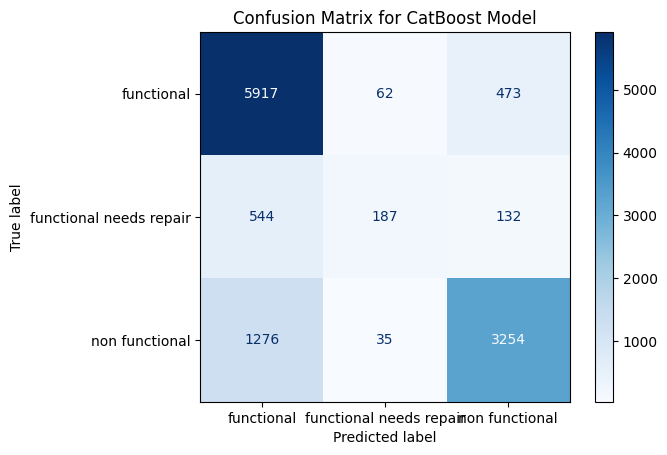

In [ ]:
# Generate confusion matrix
cb_cm = confusion_matrix(y_test, cb_preds)

# Display confusion matrix
cb_disp = ConfusionMatrixDisplay(confusion_matrix=cb_cm,
                              display_labels=cb_model.classes_)
cb_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()

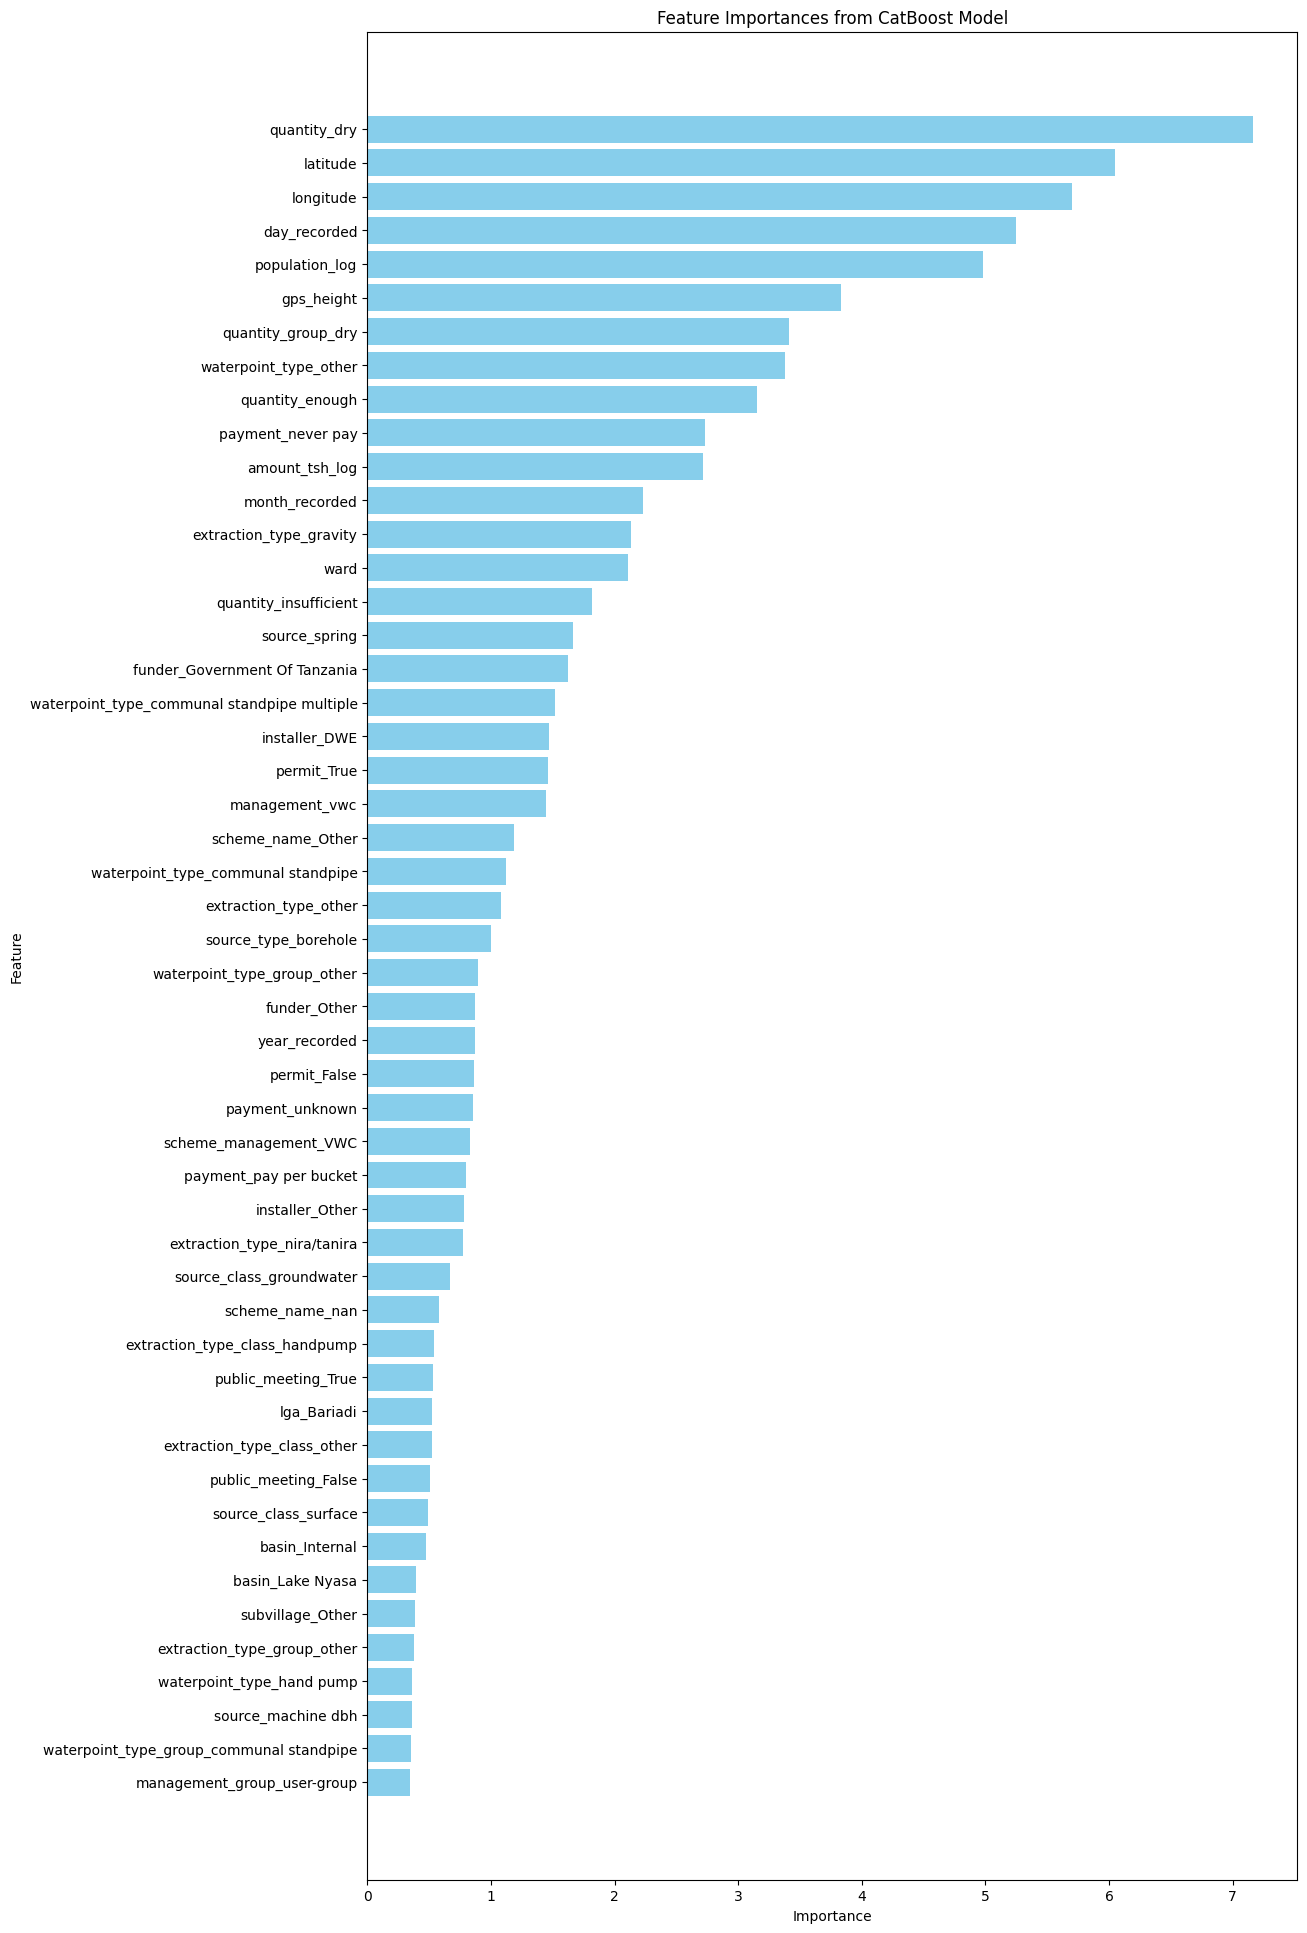

In [ ]:
# Get feature importances from the CatBoost model
cb_feature_importances = cb_model.get_feature_importance()

# Create a DataFrame for better visualization
cb_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': cb_feature_importances
})

# Sort the DataFrame by importance
cb_features_df = cb_features_df.sort_values(by='Importance', ascending=False).head(50)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(cb_features_df['Feature'], cb_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

# LGBM

In [ ]:
# Create base LGBM and HP Tuned models
base_lgbm_model = LGBMClassifier(random_state=42, max_depth=25)

# Best hyperparameters
lgbm_best_params = {
    'num_leaves': 59,
    'max_depth': 44,
    'learning_rate': 0.041786677018894554,
    'n_estimators': 824,
    'min_child_samples': 45,
    'subsample': 0.7662423547244932,
    'colsample_bytree': 0.7460637441592799,
    'reg_alpha': 0.001169447139534055,
    'reg_lambda': 0.23281199844208145
}

lgbm_model = LGBMClassifier(
    **lgbm_best_params,
    n_jobs=-1,
    random_state=42,
)

In [ ]:
# Cross-validation
base_lgbm_scores = cross_val_score(
    base_lgbm_model, X_train_final, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

lgbm_scores = cross_val_score(
    lgbm_model, X_train_final, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.413829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 864
[LightGBM] [Info] Start training from score -0.610534
[LightGBM] [Info] Start training from score -2.621328
[LightGBM] [Info] Start training from score -0.956506
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.352845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 864
[LightGBM] [Info] Start training f

In [ ]:
print(base_lgbm_scores)
print("Base LGBM mean score: ", base_lgbm_scores.mean())
print()
print(lgbm_scores)
print("Tuned LGBM mean score: ", lgbm_scores.mean())

[0.77376596 0.76789525 0.77618063 0.76919417 0.77190844]
Base LGBM mean score:  0.7717888882310632

[0.79406104 0.79265516 0.80223436 0.79684246 0.79754127]
Tuned LGBM mean score:  0.7966668570161931


In [ ]:
%%time
# LGBMClassifier
lgbm_model.fit(
    X_train_final, y_train,
#    categorical_feature='auto'
)

# Can try categorical_feature='auto' similar to CatBoost before
# encoding with OneHotEncoder (use CB version)

lgbm_preds = lgbm_model.predict(X_test_final)
print(f"Accuracy: {accuracy_score(y_test, lgbm_preds)}")
print("LGBM Classification Report:\n",
      classification_report(y_test, lgbm_preds))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2845
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 863
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493
Accuracy: 0.7982323232323232
LGBM Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.90      0.84      6452
functional needs repair       0.60      0.28      0.38       863
         non functional       0.84      0.75      0.79      4565

               accuracy                           0.80     11880
              macro avg       0.74      0.64      0.67     11880
           weighte

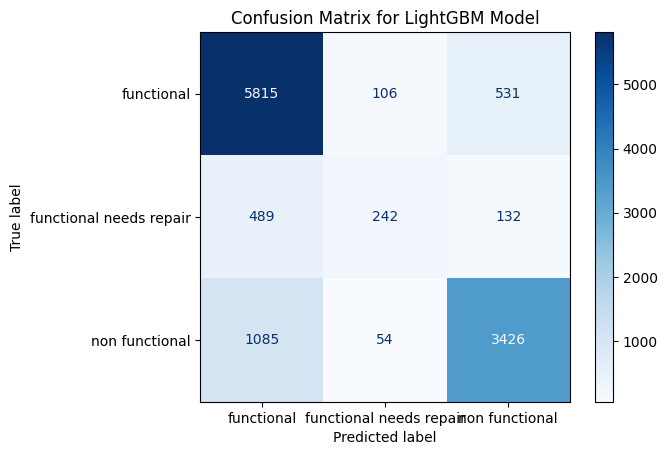

In [ ]:
# Generate confusion matrix
lgbm_cm = confusion_matrix(y_test, lgbm_preds)

# Display confusion matrix
lgbm_disp = ConfusionMatrixDisplay(
    confusion_matrix=lgbm_cm,
    display_labels=lgbm_model.classes_)
lgbm_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

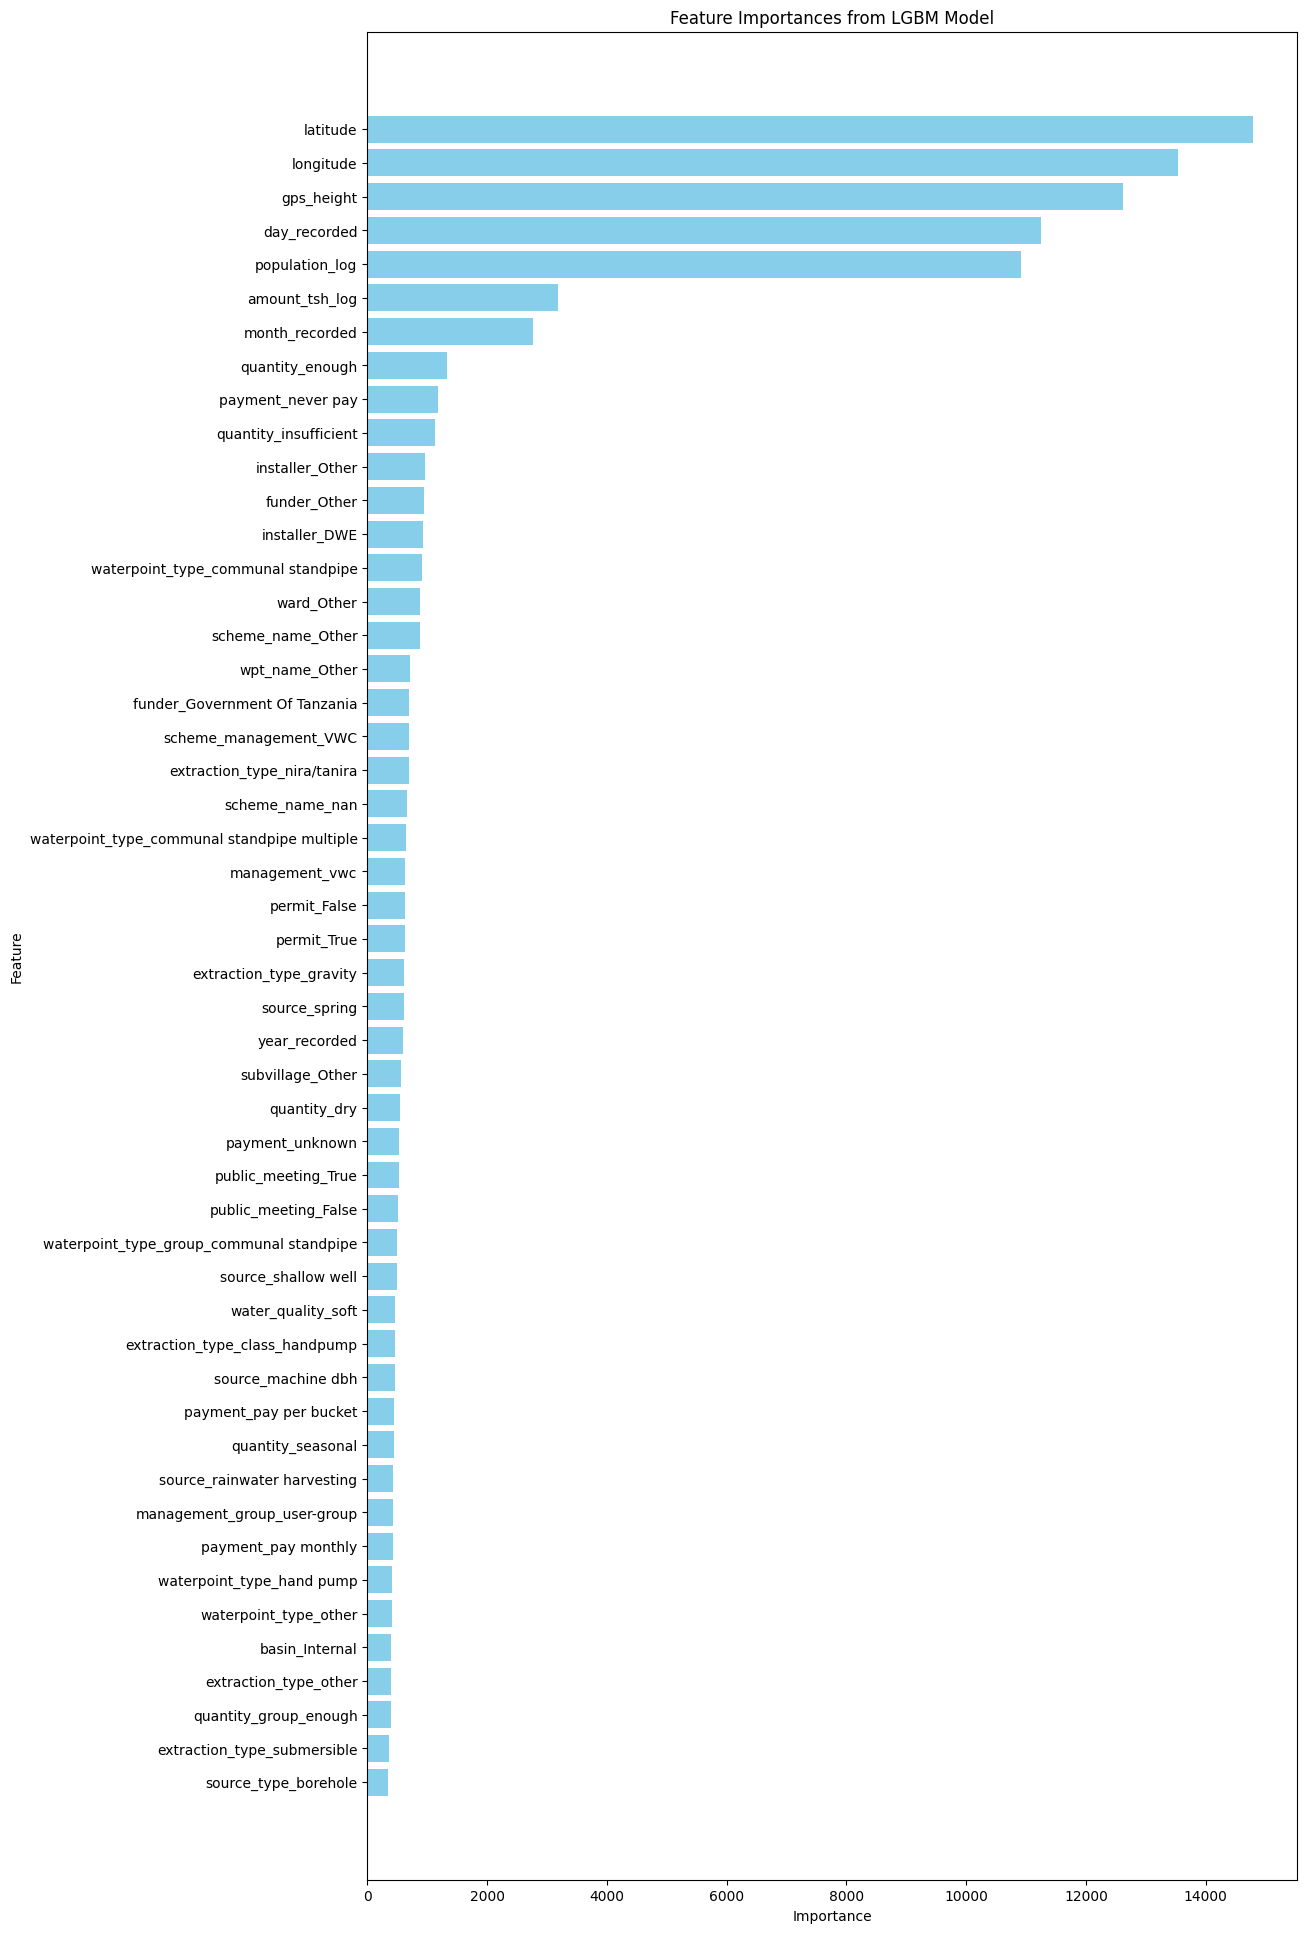

In [ ]:
# Get feature importances from the LGBM model
lgbm_feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
lgbm_features_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': lgbm_feature_importances
})

# Sort the DataFrame by importance
lgbm_features_df = lgbm_features_df.sort_values(by='Importance', ascending=False).head(50)

# Plot the feature importances
plt.figure(figsize=(12, 24))
plt.barh(lgbm_features_df['Feature'], lgbm_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from LGBM Model')
plt.gca().invert_yaxis()
plt.show()

# LGBM with internal OHE Encoding


In [ ]:
# Convert from 'object' to 'category' dtypes
X_train_cat = X_train.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)
X_test_cat = X_test.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)
test_features_cat = test_features.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)

In [ ]:
# Cross-validation
base_lgbm_auto_scores = cross_val_score(
    base_lgbm_model, X_train_cat, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

lgbm_auto_scores = cross_val_score(
    lgbm_model, X_train_cat, y_train,
    cv=stratified_kfold,
    scoring='f1_weighted')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 39
[LightGBM] [Info] Start training from score -0.610534
[LightGBM] [Info] Start training from score -2.621328
[LightGBM] [Info] Start training from score -0.956506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2104
[LightGBM] [Info] Number of data points in the train set: 38016, number of used features: 39
[LightGBM] [Info] Start training from score -0.610534
[LightGBM] [Info] Start training from score -2.621690
[LightGBM] [Info] Start 

In [ ]:
print(base_lgbm_auto_scores)
print("Base LGBM mean score: ", base_lgbm_auto_scores.mean())
print()
print(lgbm_auto_scores)
print("Tuned LGBM mean score: ", lgbm_auto_scores.mean())

[0.78583439 0.78151894 0.79762923 0.78275842 0.78815411]
Base LGBM mean score:  0.7871790211262668

[0.79708022 0.79863052 0.80443661 0.79241538 0.8026259 ]
Tuned LGBM mean score:  0.799037727060398


In [ ]:
# Try categorical_feature='auto' (similar to CatBoost)
lgbm_model.fit(
    X_train_cat, y_train,
    categorical_feature='auto'
)

lgbm_auto_preds = lgbm_model.predict(X_test_cat)
print(f"Accuracy: {accuracy_score(y_test, lgbm_auto_preds)}")
print("LGBM Classification Report:\n",
      classification_report(y_test, lgbm_auto_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2107
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 39
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.956493
Accuracy: 0.7943602693602694
LGBM Classification Report:
                          precision    recall  f1-score   support

             functional       0.79      0.89      0.84      6452
functional needs repair       0.56      0.29      0.38       863
         non functional       0.82      0.76      0.79      4565

               accuracy                           0.79     11880
              macro avg       0.73      0.64      0.67     11880
           weighted avg       0.79 

# Train final model on all data

In [ ]:
# Train on full data before predictions
X_final = pd.concat([X_train_final, X_test_final], axis=0)
y_final = pd.concat([y_train, y_test], axis=0)

# Final Predictions

In [ ]:
# Random Forest
rf_model.fit(X_final, y_final)

RandomForestClassifier(criterion='entropy', max_depth=69,
                       max_features=0.7385480758096516, min_samples_leaf=3,
                       min_samples_split=9, n_estimators=250, n_jobs=-1,
                       random_state=42)

In [ ]:
# Predict using RandomForest model
rf_test_preds = rf_model.predict(test_features_final)

# Replace values in 'status_group' with rf_test_preds
submission['status_group'] = rf_test_preds

submission.to_csv('submission_rf_0.7.csv', index=False)

In [ ]:
# CatBoost
cb_model.fit(
    Pool(X_final, y_final, cat_features=categorical_features_indices),
    eval_set=[]
)

In [ ]:
# Predict using CatBoost model
cb_test_preds = cb_model.predict(test_features_final)

# Replace values in 'status_group' with cbt_test_preds
submission['status_group'] = cb_test_preds.flatten()

submission.to_csv('submission_cb_0.1.csv', index=False)

In [ ]:
# LGBM
lgbm_model.fit(X_final, y_final)

In [ ]:
# Predict using LGBM model
lgbm_test_preds = lgbm_model.predict(test_features_final)

submission['status_group'] = lgbm_test_preds

submission.to_csv('submission_lgbm_0.1.csv', index=False)

In [ ]:
# LGBM auto
# Train on full data before predictions
X_final_cat = pd.concat([X_train_cat, X_test_cat], axis=0)

# Convert back to 'category' dtype
X_final_cat = X_final_cat.apply(
    lambda col: col.astype('category') if col.dtype == 'object' else col)

y_final_cat = pd.concat([y_train, y_test], axis=0)

lgbm_model.fit(X_final_cat, y_final_cat)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 59400, number of used features: 39
[LightGBM] [Info] Start training from score -0.610497
[LightGBM] [Info] Start training from score -2.621734
[LightGBM] [Info] Start training from score -0.956482


LGBMClassifier(colsample_bytree=0.7460637441592799,
               learning_rate=0.041786677018894554, max_depth=44,
               min_child_samples=45, n_estimators=824, n_jobs=-1, num_leaves=59,
               random_state=42, reg_alpha=0.001169447139534055,
               reg_lambda=0.23281199844208145, subsample=0.7662423547244932)

In [ ]:
# Predict using LGBM auto model
lgbm_auto_test_preds = lgbm_model.predict(test_features_cat)

submission['status_group'] = lgbm_auto_test_preds

submission.to_csv('submission_lgbm_0.2.csv', index=False)